In [15]:
import numpy as np
import math
import random
import scipy
import scipy.interpolate as sp
import scipy.io as sio
import mat73
import matplotlib.pyplot as plt
import statistics
from scipy.io import savemat
from plotly.subplots import make_subplots
import hdf5storage
scipy.io

<module 'scipy.io' from '/Users/opal_pawichaya/anaconda3/lib/python3.10/site-packages/scipy/io/__init__.py'>

In [32]:
data = scipy.io.loadmat('/Volumes/My_Passport/Go_for_Github/Example_Voltage_And_Triggers_10.mat')
# print(data)

voltage = data["voltage"]
triggers = data["triggers"] 


In [33]:
element1 = voltage[1114111, 0]
element2 = triggers[4, 999]
# print(element1, element2) 

## Analysis pABR One File ##


In [23]:
def Analyze_Parallel_ABR_One_File(voltage, triggers, f_samp = 44100, offset = 0.08 , dur = 0.035, n_noise = 32, median_flag = 1, plot_flag = 0): 
     
    offset_samps = int(np.floor(offset * f_samp)) 
    avg_samps = int(np.floor(dur * f_samp))
    trial_samps = voltage.shape[0] 
    n_freqs, n_tones = triggers.shape 

    signal = np.full((avg_samps + 1, n_freqs, n_tones), np.nan) 
    noise = np.full((avg_samps + 1, n_noise, n_tones), np.nan)

   
    for i_freq in range(n_freqs): 
        for i_tone in range(n_tones):  
            rng = np.arange(triggers[i_freq, i_tone] + offset_samps, triggers[i_freq, i_tone] + offset_samps + avg_samps + 1) 
            
            if rng[-1] < trial_samps: 
                signal[:, i_freq, i_tone] = voltage[rng,0]

    
    for i_noise in range(n_noise): 
        for i_tone in range(n_tones):
            temp = np.random.randint(trial_samps) 
            rng = np.arange(temp + offset_samps, temp + offset_samps + avg_samps + 1) 
            
            while rng[0] < 0 or rng[-1] >= trial_samps:
                temp = np.random.randint(trial_samps)    
                rng = np.arange(temp + offset_samps, temp + offset_samps + avg_samps +1)
            
            noise[:, i_noise, i_tone] = voltage[rng,0]
            continue

    if median_flag: 
        signal = np.nanmedian(signal, axis=2)    
        noise = np.nanmedian(noise, axis=2)

    if plot_flag: 
        plt.figure()
        dt = 1 / f_samp

        if median_flag:
            y_max = np.max(np.abs(signal[:])) 
        else:
            temp = np.median(signal,axis = 2)
            y_max = np.max(np.abs(temp[:]))
            
        t = np.arange(dt, (avg_samps + 1) * dt, dt)  
        
        for i_freq in range(n_freqs): 
            plt.subplot(1, n_freqs , i_freq + 1)

            if median_flag:
                plt.plot(1000 * t, noise, 'k')
                plt.plot(1000 * t, signal[:, i_freq], 'r')

            else:
                plt.plot(1000 * t, np.median(noise, axis = 1),'k')
                plt.plot(1000 * t, np.median(signal[:,i_freq,:],axis = 1),'r')

        plt.xlabel('Time (ms)')
        plt.ylim([-y_max, y_max])
        plt.gca().set_ylim([-y_max, y_max])
        plt.show()


    return signal, noise

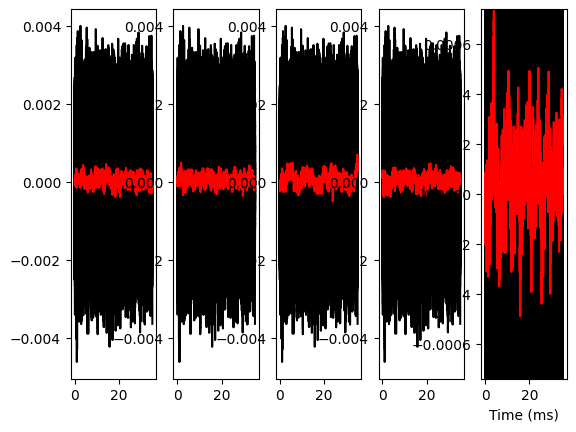

In [22]:
signal, noise = Analyze_Parallel_ABR_One_File(voltage, triggers, 44100, 0.08, 0.035, 32, 0, 1) 

In [24]:
signal_list = [] 
noise_list = []

for i in range(0, 110, 10): 
    filenames = f'/Volumes/My_Passport/Go_for_Github/Example_Voltage_And_Triggers_{i}.mat'
    all_data = scipy.io.loadmat(filenames)

    voltage = all_data["voltage"]
    triggers = all_data["triggers"] 
    
    signal, noise = Analyze_Parallel_ABR_One_File(voltage, triggers, 44100, 0.08, 0.035, 32, 0, 0)
   
    signal_list.append(signal)

    noise_list.append(noise)
    
signals = np.array(signal_list) 
signals= np.moveaxis(signals, 0, 2)
   
noises = np.array(noise_list)
noises = np.moveaxis(noises, 0, 2)

combine_data = {'Signal': signals,
                'Noise': noises}

hdf5storage.savemat('combine_data.mat', combine_data, format = 7.3, matlab_compatible = True, compress = True)



## Load Combine_data_mat_file ##

In [27]:
combine_data= hdf5storage.loadmat('combine_data.mat')

Signal = combine_data["Signal"]
Noise = combine_data["Noise"] 

In [28]:
def analyze_signal_and_noise(Signal, Noise):
    n_samps, n_freqs, n_levels, n_trials = Signal.shape
    n_noise = Noise.shape[1]
    
    avg_signal = np.median(Signal, axis=3)
    avg_noise = np.median(Noise, axis=3)
    
    tot_var = np.var(avg_signal, axis=0)
    noise_var = np.var(avg_noise, axis=0)
    
    log_tot_var = np.log(tot_var)
    
    mean_log_noise_var = np.mean(np.log(noise_var), axis=0)
    std_log_noise_var = np.std(np.log(noise_var), axis=0)
   
    mean_log_noise_var = np.tile(mean_log_noise_var, (n_freqs, 1))
    std_log_noise_var = np.tile(std_log_noise_var, (n_freqs, 1))
 
    snr_std = (log_tot_var - mean_log_noise_var) / std_log_noise_var
    
    return tot_var, noise_var, log_tot_var, mean_log_noise_var, std_log_noise_var, snr_std

In [29]:
tot_var,noise_var,log_tot_var,mean_log_noise_var,std_log_noise_var,snr_std = analyze_signal_and_noise(Signal, Noise) 

In [30]:
variables_data = {
    'tot_var': tot_var,
    'noise_var': noise_var,
    'log_tot_var': log_tot_var,
    'mean_log_noise_var': mean_log_noise_var,
    'std_log_noise_var': std_log_noise_var,
    'snr_std': snr_std
    }
savemat('Example_Signal_And_Noise_Analysis.mat', variables_data)

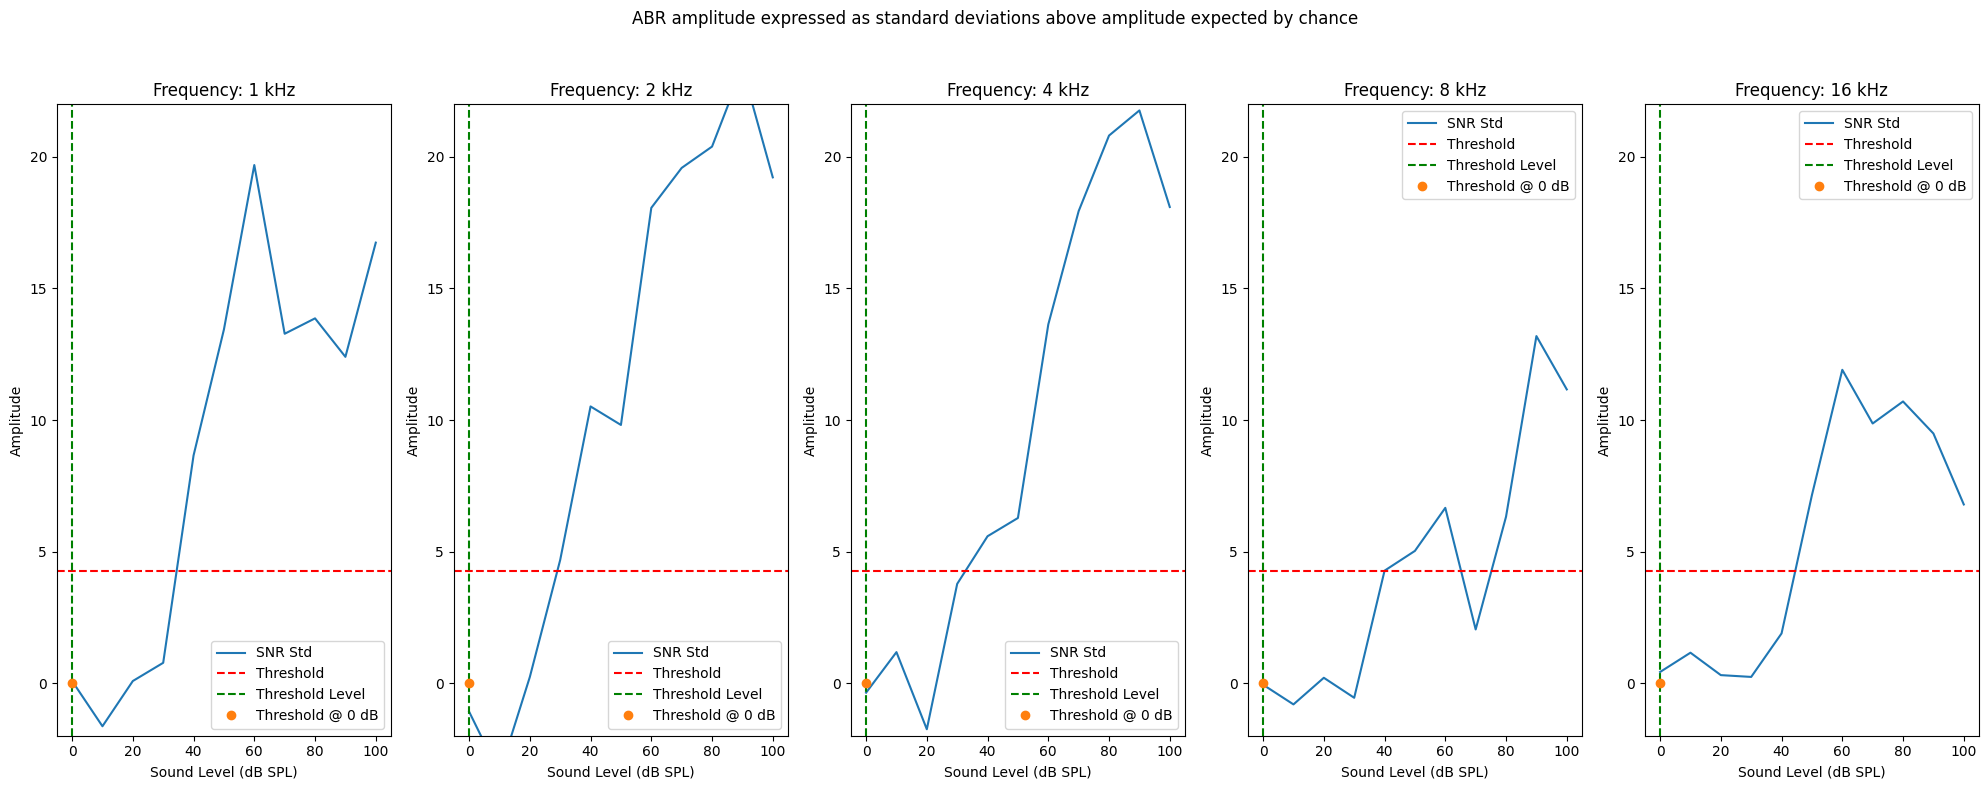

In [34]:
levels = np.arange(0, 101, 10)  
freqs = np.array([1, 2, 4, 8, 16]) 

std_thresh = 4.264  

interp_func = sp.interp1d(levels, snr_std, axis=1)
temp = interp_func(np.arange(levels[0], levels[-1] + 1))

thresh = []

plt.figure(figsize=(20, 8))
for i_freq, freq in enumerate(freqs):
    thresh_level = np.argmax(temp[:, i_freq] > std_thresh) + levels[0]
    thresh.append(thresh_level)

    plt.subplot(1, len(freqs), i_freq + 1)
    plt.plot(levels, snr_std[i_freq, :], label='SNR Std')
    plt.axhline(y=std_thresh, color='r', linestyle='--', label='Threshold')
    plt.axvline(x=thresh_level, color='g', linestyle='--', label='Threshold Level')
    plt.plot(thresh_level, 0, 'o', label=f'Threshold @ {thresh_level} dB')
    plt.ylim([-2, 22])
    plt.xlabel('Sound Level (dB SPL)')
    plt.ylabel('Amplitude')
    plt.title(f'Frequency: {freq} kHz')
    plt.legend()

plt.suptitle('ABR amplitude expressed as standard deviations above amplitude expected by chance')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()